In [60]:
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib notebook
from mpl_toolkits.mplot3d import axes3d
import random

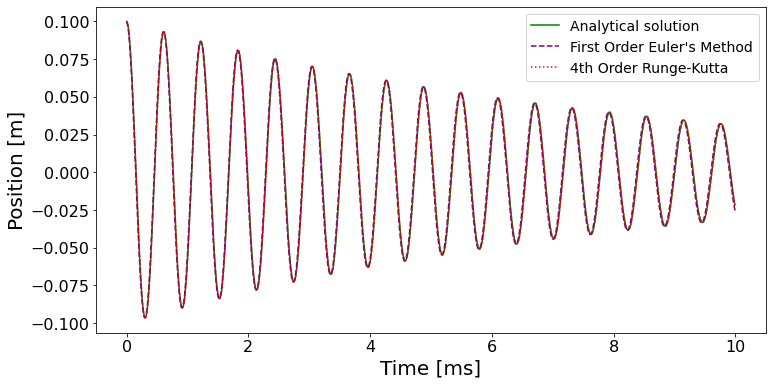

In [61]:
import nbimporter
%run DampedOscillator.ipynb

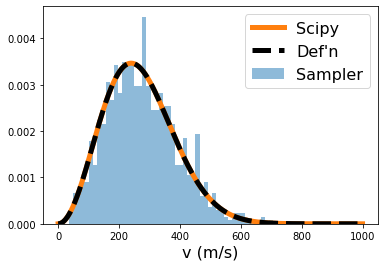

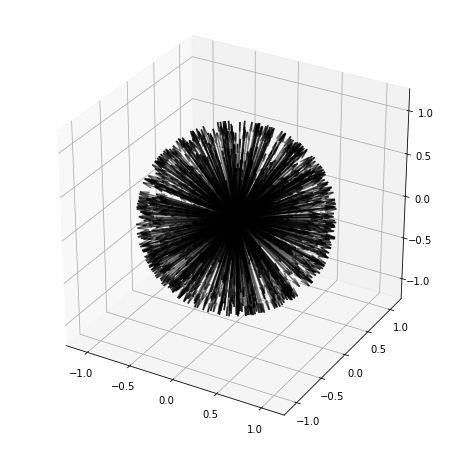

In [62]:
%run MaxwellBoltzmann.ipynb

# 1D MOT Simulation

In [63]:
# Physical Constants
hbar = 1.055 * 10**(-34) # Js, reduced Planck's constant
light_c = 2.998 * 10**(8) # m/s
BohrMag = 9.27401008 * 10**(-24) # A m^2

# Rubidium-87 Specifics
mass_Rb87 = 1.4431609 * 10**(-25) # kg
gamma = 6.06 * 10**(6) # Hz, natural line width (FWHM of D2 transition of Rb-87). Szulc.
omega_D2 = 2*np.pi* 384.2304844685 * 10**(12) # Hz. Steck.

# Apparatus
tube_diam = 2 * 10**(-3) # meters, differential pumping tube diameter
tube_length = 3 * 10**(-2) # meters, differential pumping tube length
bgrad_x = 0.11 # T/m, equal to 11 G/cm.
bgrad_y = bgrad_x

# Cell dimensions
x_len = 0.04 # m
y_len = 0.04 # m
z_len = 0.1  #m

# Beams
cooling_waist = 50 * 10**(-3) # m. Page 54 of Szulc uses elliptical profile. I use circular cross section.
push_waist = 9 * 10**(-3) # m. Page 54 Szulc.

# Optimize
s0 = 12 #12 # Optimal = 12.
det_x = -1.5*gamma # Optimal = -1.5gamma
det_y = -1.5*gamma # Optimal = -1.5gamma
det_z = -1.5*gamma

## Implementation Info
#### Storage
Positions and velocities of particles are stored as a numpy array of length 3. All functions take in a parameter called axis which must specify "x", "y", or "z". 

#### Geometry
Cooling should occur in the xy plane. 

## Forces

The radiative force takes the form of the following with $e^{-2r^2/w^2}$ representing its Gaussian profile.
$$ \vec{F}_{\pm} =s_0 e^{-2r^2/w^2}\frac{\hbar \gamma/2}{1 + s_0e^{-2r^2/w^2} + (2\Delta_{\pm}/\gamma)^2}\cdot\frac{\omega_{D2} + \delta}{c}\hat{k}_{\pm} $$
where for the x-axis, for example:
$$ \Delta_{\pm} = \delta \mp kv_x \mp \text{sign}(x)\frac{|\tilde{\mu}B(x)|}{2\pi\hbar}$$
where $\tilde{\mu} = \frac{2}{3}\mu_B$ for the D2 line of Rb-87, and $B(x) = bx$, $b>0$.

# 1D MOT: Damping Demonstration

In [110]:
def getDeltaPM(x, v, det, bgrad):
    term1 = det
    term2 = ((omega_D2 + 2*np.pi*det)/(light_c))*v 
    term3 = np.sign(x)*np.abs((2/3)*BohrMag*bgrad*x)/(2*np.pi*hbar)
    Delta_plus = term1 - term2 - term3
    Delta_minus = term1 + term2 + term3
    return Delta_plus, Delta_minus

# Helper function for radiative force.
def radiativeHelper(Delta_plus, Delta_minus, det, s_adjusted):
    k = (omega_D2 + 2*np.pi*det)/(light_c)
    F_plus = k * (hbar*s_adjusted*(gamma/2))/(1 + s_adjusted + (2*Delta_plus/gamma)**2)
    F_minus = k * (hbar*s_adjusted*(gamma/2))/(1 + s_adjusted + (2*Delta_minus/gamma)**2)
    return F_plus - F_minus

# ratio = s0_{-}/s0_{+} = push/counterpush. s_adj = counterpush.
def pushHelper(Delta_plus, Delta_minus, det, s_adjusted, ratio=1):
    k = (omega_D2 + 2*np.pi*det)/(light_c)
    F_plus = k * (hbar*s_adjusted*(gamma/2))/(1 + s_adjusted + (2*Delta_plus/gamma)**2)
    F_minus = k * (hbar*ratio*s_adjusted*(gamma/2))/(1 + ratio*s_adjusted + (2*Delta_minus/gamma)**2)
    return F_plus, F_minus

In [65]:
def forceRadiative_x(x0, v0, axis=0):    
    # Check axis:
    det = np.NaN
    bgrad = np.NaN
    r_squared = np.NaN
    if axis == 0:
        det = det_x
        bgrad = bgrad_x
    elif axis == 1:
        det = det_y
        bgrad = bgrad_y
    elif axis == 2:
        print("do nothing") 
    
    # Compute Delta_{pm}
    Delta_plus, Delta_minus = getDeltaPM(x0, v0, det, bgrad)
    
    # Compute s_adjusted, which is s0 * e^{-2r^2/w^2}
    r_squared = 0 # FOR NOW, NO BEAM WAIST
    s_adjusted = s0 * np.exp(-2*r_squared/(cooling_waist**2))
    
    # Compute Force
    force = radiativeHelper(Delta_plus, Delta_minus, det, s_adjusted)
    
    return force

def runEuler_x(x0, v0, m=mass_Rb87, dt=10 * 10**(-6), num_timesteps=1000, axis=0):
    # Initialize state:
    xn = x0
    vn = v0

    # Data storage
    positions = []
    positions.append(xn)  # Store x0
    velocities = []
    velocities.append(vn) # Store v0
    times = []
    times.append(0)
    forces = []
    forces.append(0)
    

    # Euler Loop
    for j in range(0, num_timesteps):
        force = forceRadiative_x(xn, vn, axis=axis)
        forces.append(force)
        vdot = force/m
        #print("4) vdot", vdot)
        vn = vn + dt*vdot
        #print("5) vn", vn)
        xn = xn + dt*vn

        # Update storage
        positions.append(xn)
        velocities.append(vn)
        times.append((j+1)*dt)
     
    return np.array(times), np.array(positions), np.array(velocities), np.array(forces)

def runRK4_x(force, x0, v0, m=mass_Rb87, dt=10 * 10**(-6), num_timesteps=1000):
    # Initialize state:
    xn = x0
    vn = v0
    
    # Data storage
    positions = []
    positions.append(xn)  # Store x0
    velocities = []
    velocities.append(vn) # Store v0
    times = []
    times.append(0)
    
    # RK4 Loop
    for j in range(0, num_timesteps):
        K1 = force(xn, vn)/m
        L1 = vn
        
        K2 = force(xn + dt*L1/2, vn + dt*K1/2)/m
        L2 = vn + dt*K1/2
        
        K3 = force(xn + dt*L2/2, vn + dt*K2/2)/m
        L3 = vn + dt*K2/2
        
        K4 = force(xn + dt*L3, vn + dt*K3)/m
        L4 = vn + dt*K3
        
        # Update xn and vn
        xn = xn + (dt/6)*(L1 + 2*L2 + 2*L3 + L4)
        vn = vn + (dt/6)*(K1 + 2*K2 + 2*K3 + K4)
        
        
        # Store these new xn, vn:
        positions.append(xn)
        velocities.append(vn)
        times.append((j+1) * dt)
    
    return np.array(times), np.array(positions), np.array(velocities)

Text(0, 0.5, 'F (N)')

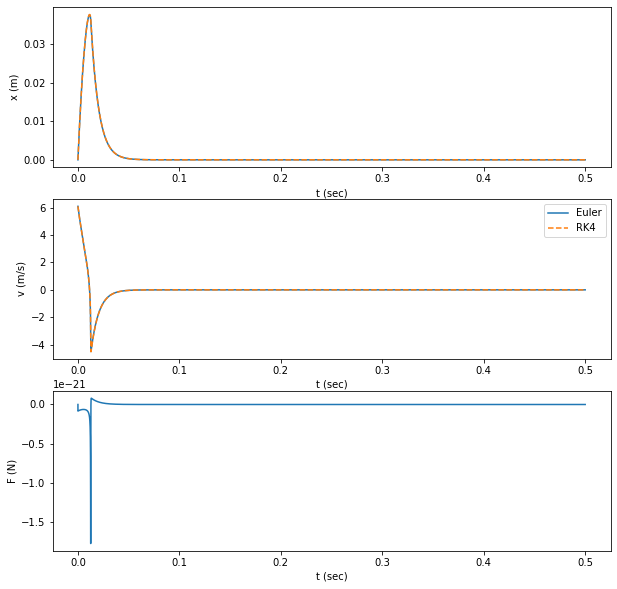

In [66]:
# Radiative force should caused damped harmonic oscillator for small x_0, small v_x.
# Testing:
num_time = 50000

# Initialize an atom with these velocities
x0 = 0

vx = 6.1 # m/s

tt, xx, vv, ff = runEuler_x(x0, vx, num_timesteps=num_time)
ttt, xxx, vvv = runRK4_x(forceRadiative_x, x0, vx, num_timesteps=num_time)

# positions
fig, ax = plt.subplots(3, 1, figsize=(10, 10))

# x-pos
ax[0].plot(tt, xx, label="Euler")
ax[0].set_xlabel("t (sec)")
ax[0].set_ylabel("x (m)")

ax[0].plot(ttt, xxx, label="RK4", ls="--")

#v-pos
ax[1].plot(tt, vv, label="Euler")
ax[1].set_xlabel("t (sec)")
ax[1].set_ylabel("v (m/s)")
ax[1].plot(ttt, vvv, label="RK4", ls="--")
ax[1].legend()

ax[2].plot(tt, ff)
ax[2].set_xlabel("t (sec)")
ax[2].set_ylabel("F (N)")

## Full Sim

In [119]:
def forcePush(x0, v0, det, bgrad, s_adj):
    # Compute Delta_{pm}. No magnetic field in this direction.
    Delta_plus, Delta_minus = getDeltaPM(x0, v0, det, 0)
    # Compute Force 
    fplus, fminus = pushHelper(Delta_plus, Delta_minus, det, s_adj)
    return fplus - fminus 

def forceRad(x0, v0, det, bgrad, s_adj):    
    # Compute Delta_{pm}
    Delta_plus, Delta_minus = getDeltaPM(x0, v0, det, bgrad)
    # Compute Force
    force = radiativeHelper(Delta_plus, Delta_minus, det, s_adj)
    return force

def RK4_step(force, xn, yn, zn, vn, axis, dt, m=mass_Rb87):
        
        # Initialize parameters
        r_squared = np.NaN
        waist = np.NaN
        det = np.NaN
        bgrad = np.NaN
        
        # Position variable
        pn = -10e9
        
        if axis == 0:
            r_squared = yn**2 + zn**2
            waist = cooling_waist
            det = det_x
            bgrad = bgrad_x
            pn = xn
        elif axis == 1:
            r_squared = xn**2 + yn**2
            waist = cooling_waist
            det = det_y
            bgrad = bgrad_y
            pn = yn
        elif axis == 2:
            r_squared = xn**2 + yn**2
            waist = push_waist
            det = det_z
            bgrad = 0
            pn = zn
            
        # FOR NOW, DON'T ADJUST s0 for GAUSSIAN PROF.:
        r_squared = 0
        s_adj = s0 * np.exp(-2*r_squared/(waist**2))
        # DELETE ABOVE SOON.
        
        # Make an RK4 STEP.
        K1 = force(pn, vn, det, bgrad, s_adj)/m
        L1 = vn
        
        K2 = force(pn + dt*L1/2, vn + dt*K1/2, det, bgrad, s_adj)/m
        L2 = vn + dt*K1/2
        
        K3 = force(pn + dt*L2/2, vn + dt*K2/2, det, bgrad, s_adj)/m
        L3 = vn + dt*K2/2
        
        K4 = force(pn + dt*L3, vn + dt*K3, det, bgrad, s_adj)/m
        L4 = vn + dt*K3
        
        # Update xn and vn
        pn = pn + (dt/6)*(L1 + 2*L2 + 2*L3 + L4)
        vn = vn + (dt/6)*(K1 + 2*K2 + 2*K3 + K4)
        
        return pn, vn, K1*m # return force for logging

# Step in simulation.
def step(forceRad, forcePush, vec_x, vec_v, dt):
    # Unpack vec_x
    xn, yn, zn = vec_x
    # Unpack vec_v
    vxn, vyn, vzn = vec_v
    
    # Time-evolve
    # x-direction
    xn, vxn, force_x = RK4_step(forceRad, xn, yn, zn, vxn, axis=0, dt=dt)
    # y-direction
    yn, vyn, force_y = RK4_step(forceRad, xn, yn, zn, vyn, axis=1, dt=dt)
    # z-direction
    zn, vzn, force_z = RK4_step(forcePush, xn, yn, zn, vzn, axis=2, dt=dt)
    #zn = zn + vzn*dt
    #force_z = 0
    
    return np.array([xn, yn, zn]), np.array([vxn, vyn, vzn]), np.array([force_x, force_y, force_z])
    
# Initial position and velocity vectors: vec_x, vec_v
def simulate(vec_x, vec_v, dt=10 * 10**(-6), num_timesteps=10000, m=mass_Rb87):
    # Storage
    positions = []
    positions.append(np.copy(vec_x))
    velocities = []
    velocities.append(np.copy(vec_v))
    times = []
    times.append(0)
    forces = []
    
    # Flag for success. 1 =  True. 0 = False.
    success = 1 # So I get atoms that reached science chamber and trapped atoms
    
    for j in range(0, num_timesteps):
        vec_x, vec_v, vec_force = step(forceRad, forcePush, vec_x, vec_v, dt)    
        positions.append(np.copy(vec_x))
        velocities.append(np.copy(vec_v))
        times.append((j+1) * dt)
        forces.append(np.copy(vec_force))
        
        if aboveCell(vec_x):
            if checkTubeCollision(vec_x):
                success=0
                break
            else: # if in tube and no collision, check if reached science chamber.
                if reachedScienceChamber(vec_x):
                    success=1
                    break
                    
        elif checkCollision(vec_x): # If it's not in the tube, it checks for cell collision.
            success=0
            break
        
    return np.array(positions), np.array(velocities), np.array(times), np.array(forces), success

# Return true if science chamber z (z_len/2 + tube_length) is acquired
def reachedScienceChamber(vec_x):
    x, y, z = vec_x
    if z > ((z_len/2) + tube_length):
        return True

# Return true if its above the cell.
def aboveCell(vec_x):
    x, y, z = vec_x
    if z > z_len/2:
        return True

# Assumption is that it the atom is in the tube (above cell)
def checkTubeCollision(vec_x):
    x, y, z = vec_x
    # Check collision in tube:
    if np.sqrt(x**2 + y**2) > tube_diam/2:
        return True 

# Return true if collision within the cell.
def checkCollision(vec_x):
    x, y, z = vec_x
    # It's in the cell, check for collisions.
    if np.abs(x) > x_len/2 or np.abs(y) > y_len/2 or z < -z_len/2:
        return True
    else:
        return False

In [120]:
N_sim = 1000
vcut = 30 #m/s

pos_rec = []
vel_rec = []
times_rec = []
forces_rec = []
successes = 0
success_index = []

for n in range(0, N_sim):
    # Find a velocity vector below the cut
    smp = sampleVelocityVec()
    while np.linalg.norm(smp) > vcut:
        smp = sampleVelocityVec()
    
    # Initialize atom
    vec_x = np.array([0,0,0])
    #sc = 10**(-5)
    #vec_x = np.array([sc*st.uniform.rvs(loc = -0.5, scale=1), sc*st.uniform.rvs(loc = -0.5, scale=1), sc*st.uniform.rvs(loc = -0.5, scale=1)])
    #vec_v = np.array([smp[0], smp[1], 10])
    vec_v = np.array([smp[0], smp[1], smp[2]]) # Fully correct
    #vec_v = np.array([30*st.uniform.rvs(loc = -0.5, scale=1), 30*st.uniform.rvs(loc = -0.5, scale=1), 0.3])
    pos, vel, times, forces, success = simulate(vec_x, vec_v, num_timesteps=10000)
    if success == 1:
        successes += 1
        success_index.append(n)
        print("Success at n = ", n)
    pos_rec.append(pos)
    vel_rec.append(vel)
    forces_rec.append(forces)
    times_rec.append(times)
    if n % 10 == 0:
        print("Done with run ", n)

print("Successful: ", successes)
print("Success index: ", success_index)

Done with run  0
Done with run  10
Done with run  20
Done with run  30
Done with run  40
Success at n =  41
Success at n =  43
Success at n =  50
Done with run  50
Done with run  60
Done with run  70
Done with run  80
Done with run  90
Done with run  100
Done with run  110
Done with run  120
Done with run  130
Success at n =  135
Done with run  140
Done with run  150
Done with run  160
Done with run  170
Success at n =  174
Done with run  180
Success at n =  184
Done with run  190
Done with run  200
Done with run  210
Done with run  220
Done with run  230
Done with run  240
Done with run  250
Done with run  260
Done with run  270
Success at n =  280
Done with run  280
Success at n =  289
Done with run  290
Done with run  300
Done with run  310
Success at n =  318
Done with run  320
Done with run  330
Success at n =  340
Done with run  340
Done with run  350
Done with run  360
Done with run  370
Done with run  380
Done with run  390
Done with run  400
Done with run  410
Done with run  4

Initial velocity:  [4.16294792 4.95648348 4.14920158]


Text(0, 0.5, 'F_z (N)')

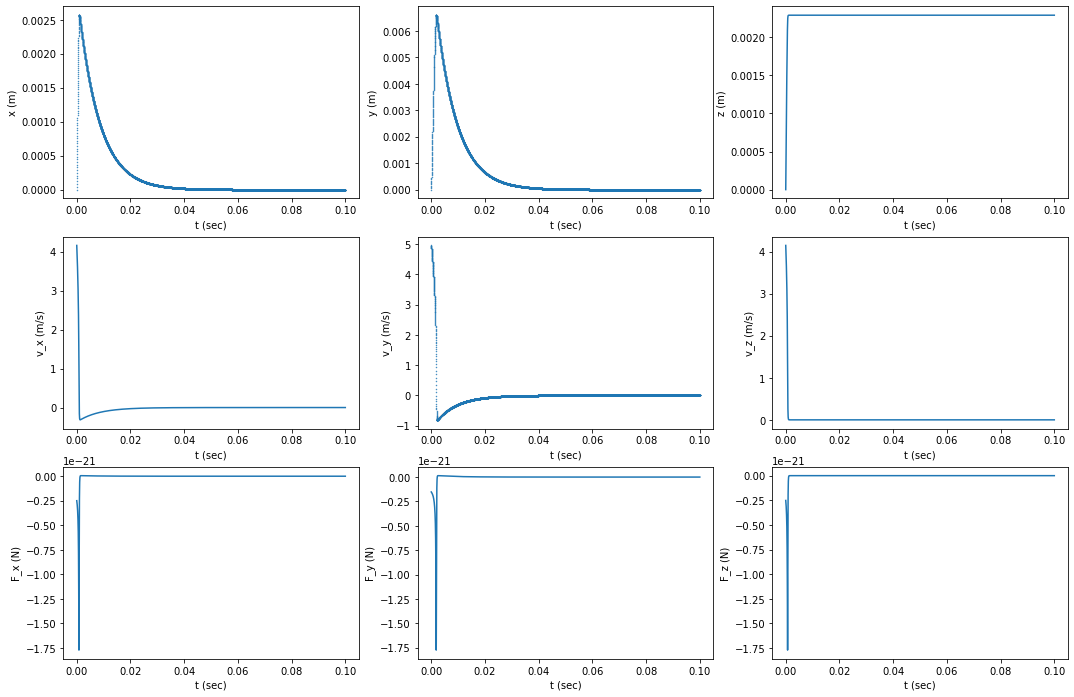

In [121]:
# positions
fig, ax = plt.subplots(3, 3, figsize=(18, 12))

sim = True
if sim:
    nnn=41
    pos = pos_rec[nnn]
    vel = vel_rec[nnn]
    print("Initial velocity: ", vel[0])
    forces = forces_rec[nnn]
    times = times_rec[nnn]

# x-pos (TOP LEFT)
ax[0,0].scatter(times, pos[:, 0], label="RK4", s=0.2)
ax[0,0].set_xlabel("t (sec)")
ax[0,0].set_ylabel("x (m)")

# v_x (middle LEFT)
ax[1,0].plot(times, vel[:, 0], label="RK4")
ax[1,0].set_xlabel("t (sec)")
ax[1,0].set_ylabel("v_x (m/s)")

# F_x (bottom LEFT)
ax[2,0].plot(times[1:], forces[:, 0], label="RK4")
ax[2,0].set_xlabel("t (sec)")
ax[2,0].set_ylabel("F_x (N)")

# y-pos (TOP CENTER)
ax[0, 1].scatter(times, pos[:, 1], label="RK4", s=0.2)
ax[0, 1].set_xlabel("t (sec)")
ax[0, 1].set_ylabel("y (m)")

# v_y (BOTTOM CENTER)
ax[1, 1].scatter(times, vel[:, 1], label="RK4", s=0.2)
ax[1, 1].set_xlabel("t (sec)")
ax[1, 1].set_ylabel("v_y (m/s)")

# F_y (bottom middle)
ax[2,1].plot(times[1:], forces[:, 1], label="RK4")
ax[2,1].set_xlabel("t (sec)")
ax[2,1].set_ylabel("F_y (N)")


# z-pos (TOP RIGHT)
ax[0, 2].plot(times, pos[:, 2], label="RK4")
ax[0, 2].set_xlabel("t (sec)")
ax[0, 2].set_ylabel("z (m)")

# v_z (BOTTOM RIGHT)
ax[1, 2].plot(times, vel[:, 2], label="RK4")
ax[1, 2].set_xlabel("t (sec)")
ax[1, 2].set_ylabel("v_z (m/s)")

# F_z (bottom middle)
ax[2,2].plot(times[1:], forces[:, 2], label="RK4")
ax[2,2].set_xlabel("t (sec)")
ax[2,2].set_ylabel("F_z (N)")

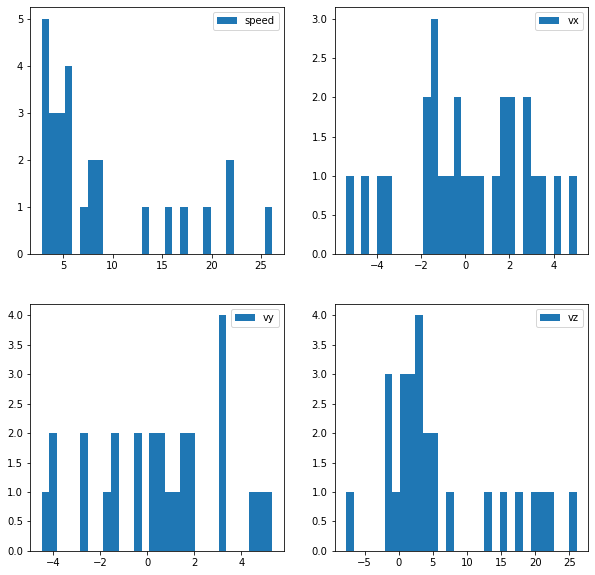

In [122]:
# Make a histogram of the trapped speeds
speeds = []
vxs = []
vys = []
vzs = []
fig, ax = plt.subplots(2,2, figsize=(10,10))
for n in success_index:
    vel = vel_rec[n][0]
    spd = np.sqrt(np.sum(vel**2))
    speeds.append(spd)
    vxs.append(vel[0])
    vys.append(vel[1])
    vzs.append(vel[2])
    
ax[0,0].hist(speeds, bins=30, label="speed")
ax[0,0].legend()
ax[0,1].hist(vxs, bins=30, label="vx")
ax[0,1].legend()
ax[1,0].hist(vys, bins=30, label="vy")
ax[1,0].legend()
ax[1,1].hist(vzs, bins=30, label="vz")
ax[1,1].legend()

### In the cell:

Text(0.5, 0, 'z (m)')

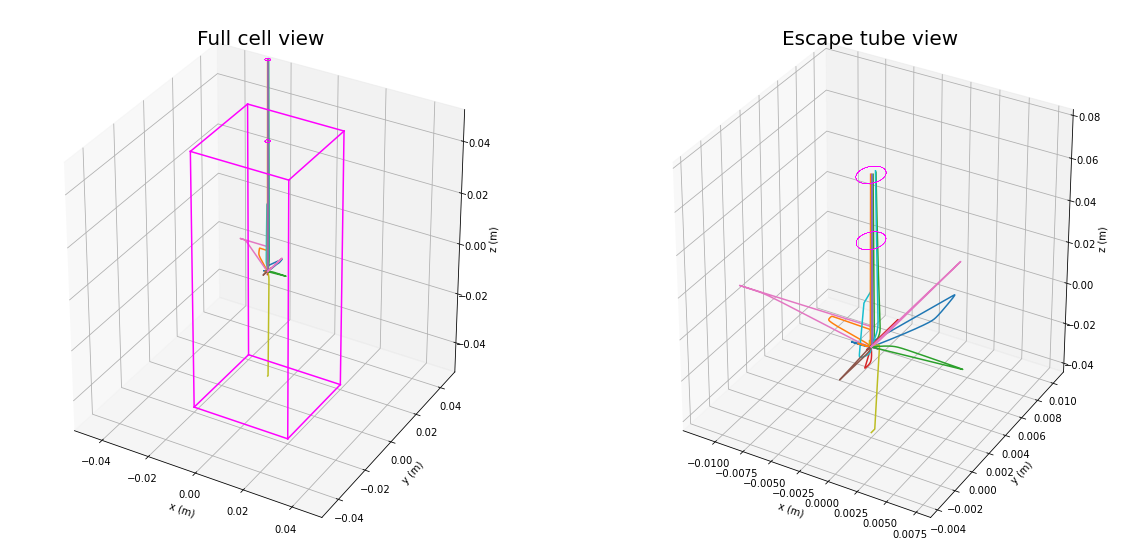

In [126]:
fig = plt.figure(figsize=(20,10)) 
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_zlabel("z (m)")
ax.set_title("Full cell view", fontsize=20)

show = True
successfulOnly = True
if show:
    if successfulOnly:
        for n in success_index:
            pos = pos_rec[n]
            ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])
    else:
        plotN = 10
        for i in range(0, plotN):
            pos = pos_rec[random.randint(0, N_sim-1)]
            ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])

#  [200, 243, 597, 614, 656, 687, 690, 829, 833, 915, 919]
sim = False
if sim:
    nnn= 9535
    pos = pos_rec[nnn]
    vel = vel_rec[nnn]
    forces = forces_rec[nnn]
    times = times_rec[nnn]
    ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])
        
# Build cell:
showCell = True
showTube = True
if showCell:
    cell_x = np.linspace(-x_len/2, x_len/2, 1000)
    ax.plot(cell_x, (y_len/2)*np.ones_like(cell_x), (z_len/2)*np.ones_like(cell_x), c="magenta")
    ax.plot(cell_x, (y_len/2)*np.ones_like(cell_x), -(z_len/2)*np.ones_like(cell_x), c="magenta")
    ax.plot(cell_x, -(y_len/2)*np.ones_like(cell_x), (z_len/2)*np.ones_like(cell_x), c="magenta")
    ax.plot(cell_x, -(y_len/2)*np.ones_like(cell_x), -(z_len/2)*np.ones_like(cell_x), c="magenta")
    cell_y = np.linspace(-y_len/2, y_len/2, 1000)
    ax.plot((x_len/2)*np.ones_like(cell_x), cell_y, (z_len/2)*np.ones_like(cell_x), c="magenta")
    ax.plot((x_len/2)*np.ones_like(cell_x), cell_y, -(z_len/2)*np.ones_like(cell_x), c="magenta")
    ax.plot(-(x_len/2)*np.ones_like(cell_x), cell_y, (z_len/2)*np.ones_like(cell_x), c="magenta")
    ax.plot((-x_len/2)*np.ones_like(cell_x), cell_y, -(z_len/2)*np.ones_like(cell_x), c="magenta")
    cell_z = np.linspace(-z_len/2, z_len/2, 1000)
    ax.plot((x_len/2)*np.ones_like(cell_x), (y_len/2)*np.ones_like(cell_x), cell_z, c="magenta")
    ax.plot((x_len/2)*np.ones_like(cell_x), -(y_len/2)*np.ones_like(cell_x), cell_z, c="magenta")
    ax.plot(-(x_len/2)*np.ones_like(cell_x), (y_len/2)*np.ones_like(cell_x), cell_z, c="magenta")
    ax.plot((-x_len/2)*np.ones_like(cell_x), -(y_len/2)*np.ones_like(cell_x), cell_z, c="magenta")

    displayoption = False
    if displayoption:
        ax.set_xlim(-0.5*x_len, 0.5*x_len)
        ax.set_ylim(-0.5*y_len, 0.5*y_len)
        ax.set_zlim(-0.5*z_len, 0.5*z_len)
    else:
        ax.set_xlim(-0.5*z_len, 0.5*z_len)
        ax.set_ylim(-0.5*z_len, 0.5*z_len)
        ax.set_zlim(-0.5*z_len, 0.5*z_len)

# Build hole
if showTube:
    # Tube left fig
    uuu = np.linspace(0, 100, 10000)
    ax.plot((tube_diam/2)*np.cos(uuu), (tube_diam/2)*np.sin(uuu), z_len/2, c="magenta", lw=0.1)
    ax.plot((tube_diam/2)*np.cos(uuu), (tube_diam/2)*np.sin(uuu), z_len/2 + tube_length, c="magenta", lw=0.1)
    
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    # Plot:
    if show:
        if successfulOnly:
            for n in success_index:
                pos = pos_rec[n]
                ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])
    else:
        plotN = 10
        for i in range(0, plotN):
            pos = pos_rec[random.randint(0, N_sim-1)]
            ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])
    
    
    
    # Tube right fig
    uuu = np.linspace(0, 100, 10000)
    ax.plot((tube_diam/2)*np.cos(uuu), (tube_diam/2)*np.sin(uuu), z_len/2, c="magenta", lw=0.1)
    ax.plot((tube_diam/2)*np.cos(uuu), (tube_diam/2)*np.sin(uuu), z_len/2 + tube_length, c="magenta", lw=0.1)
    
    tubeCenter = False
    if tubeCenter:
        ax.set_xlim(-0.007*z_len, 0.007*z_len)
        ax.set_ylim(-0.007*z_len, 0.007*z_len)
        #ax.set_zlim(-0.007*z_len, 0.007*z_len)

ax.set_title("Escape tube view", fontsize=20)
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_zlabel("z (m)")

### Random

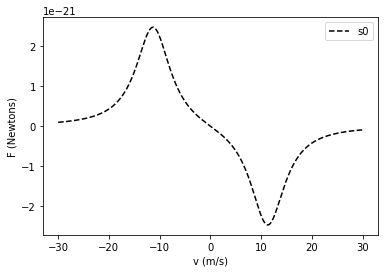

In [112]:
# Proof that pushHelper works.
varr = np.linspace(-30**1, 30**1, 10000)
x = 0
det = 10*det_x
s00 = 10*s0
plus, minus = getDeltaPM(x, varr, det, 0)

force = radiativeHelper(plus, minus, det, s00)

plt.plot(varr, force, label="s0", ls="--", c="k")
plt.xlabel("v (m/s)")
plt.ylabel("F (Newtons)")
plt.legend()

In [ ]:
# TODO:
#Fix push beam
#Check conditions for wall

In [52]:
z_len/2 + tube_length

0.08

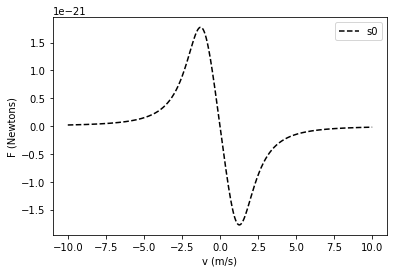

In [118]:
# Proof that pushHelper works.
varr = np.linspace(-10**1, 10**1, 10000)
x = 10
det = det_z
s00 = s0
plus, minus = getDeltaPM(x, varr, det, 0)

fplus, fminus = pushHelper(plus, minus, det, s00)

plt.plot(varr, fplus-fminus, label="s0", ls="--", c="k")
plt.xlabel("v (m/s)")
plt.ylabel("F (Newtons)")
plt.legend()